In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair
import sklearn
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold

In [2]:
df = pd.read_csv('/kaggle/input/teton-dataset-2000-23/dataset0_23.csv')

train_df = pd.read_csv('/kaggle/input/teton-dataset-2000-23/train_data0_23.csv')

test_df = pd.read_csv('/kaggle/input/teton-dataset-2000-23/test_data0_23.csv')

In [3]:
df.describe()

,Temperature,Moisture,Watering
count,3672.000000,3672.000000,3672.000000
mean,32.493736,62.348856,165.465142
std,4.610987,13.212965,20.594234
min,25.000000,40.000000,130.000000
25%,28.000000,51.000000,148.000000
50%,33.000000,62.000000,166.000000
75%,37.000000,74.000000,183.000000
max,40.000000,85.000000,200.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         3672 non-null   object
 1   Temperature  3672 non-null   int64 
 2   Moisture     3672 non-null   int64 
 3   Watering     3672 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 114.9+ KB


In [5]:
df.head(10)

,Date,Temperature,Moisture,Watering
0,2000-04-01,30,64,142
1,2000-04-02,39,41,183
2,2000-04-03,33,60,193
3,2000-04-04,34,56,174
4,2000-04-05,25,42,130
5,2000-04-06,37,47,135
6,2000-04-07,33,75,184
7,2000-04-08,30,52,156
8,2000-04-09,35,61,145
9,2000-04-10,38,43,145


In [6]:
def features(data):
    df = data.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    
    df['month'] = df['Date'].dt.strftime('%B')
    df['year'] = df['Date'].dt.strftime('%Y')
    df['dayofweek'] = df['Date'].dt.strftime('%A')
    df['quarter'] = df['Date'].dt.quarter
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.isocalendar().week
    
    return df

In [7]:
data = features(df)
data.head()

,Date,Temperature,Moisture,Watering,month,year,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
0,2000-04-01,30,64,142,April,2000,Saturday,2,92,1,13
1,2000-04-02,39,41,183,April,2000,Sunday,2,93,2,13
2,2000-04-03,33,60,193,April,2000,Monday,2,94,3,14
3,2000-04-04,34,56,174,April,2000,Tuesday,2,95,4,14
4,2000-04-05,25,42,130,April,2000,Wednesday,2,96,5,14


In [8]:
print(data.columns)

Index(['Date', 'Temperature', 'Moisture', 'Watering', 'month', 'year',
       'dayofweek', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')


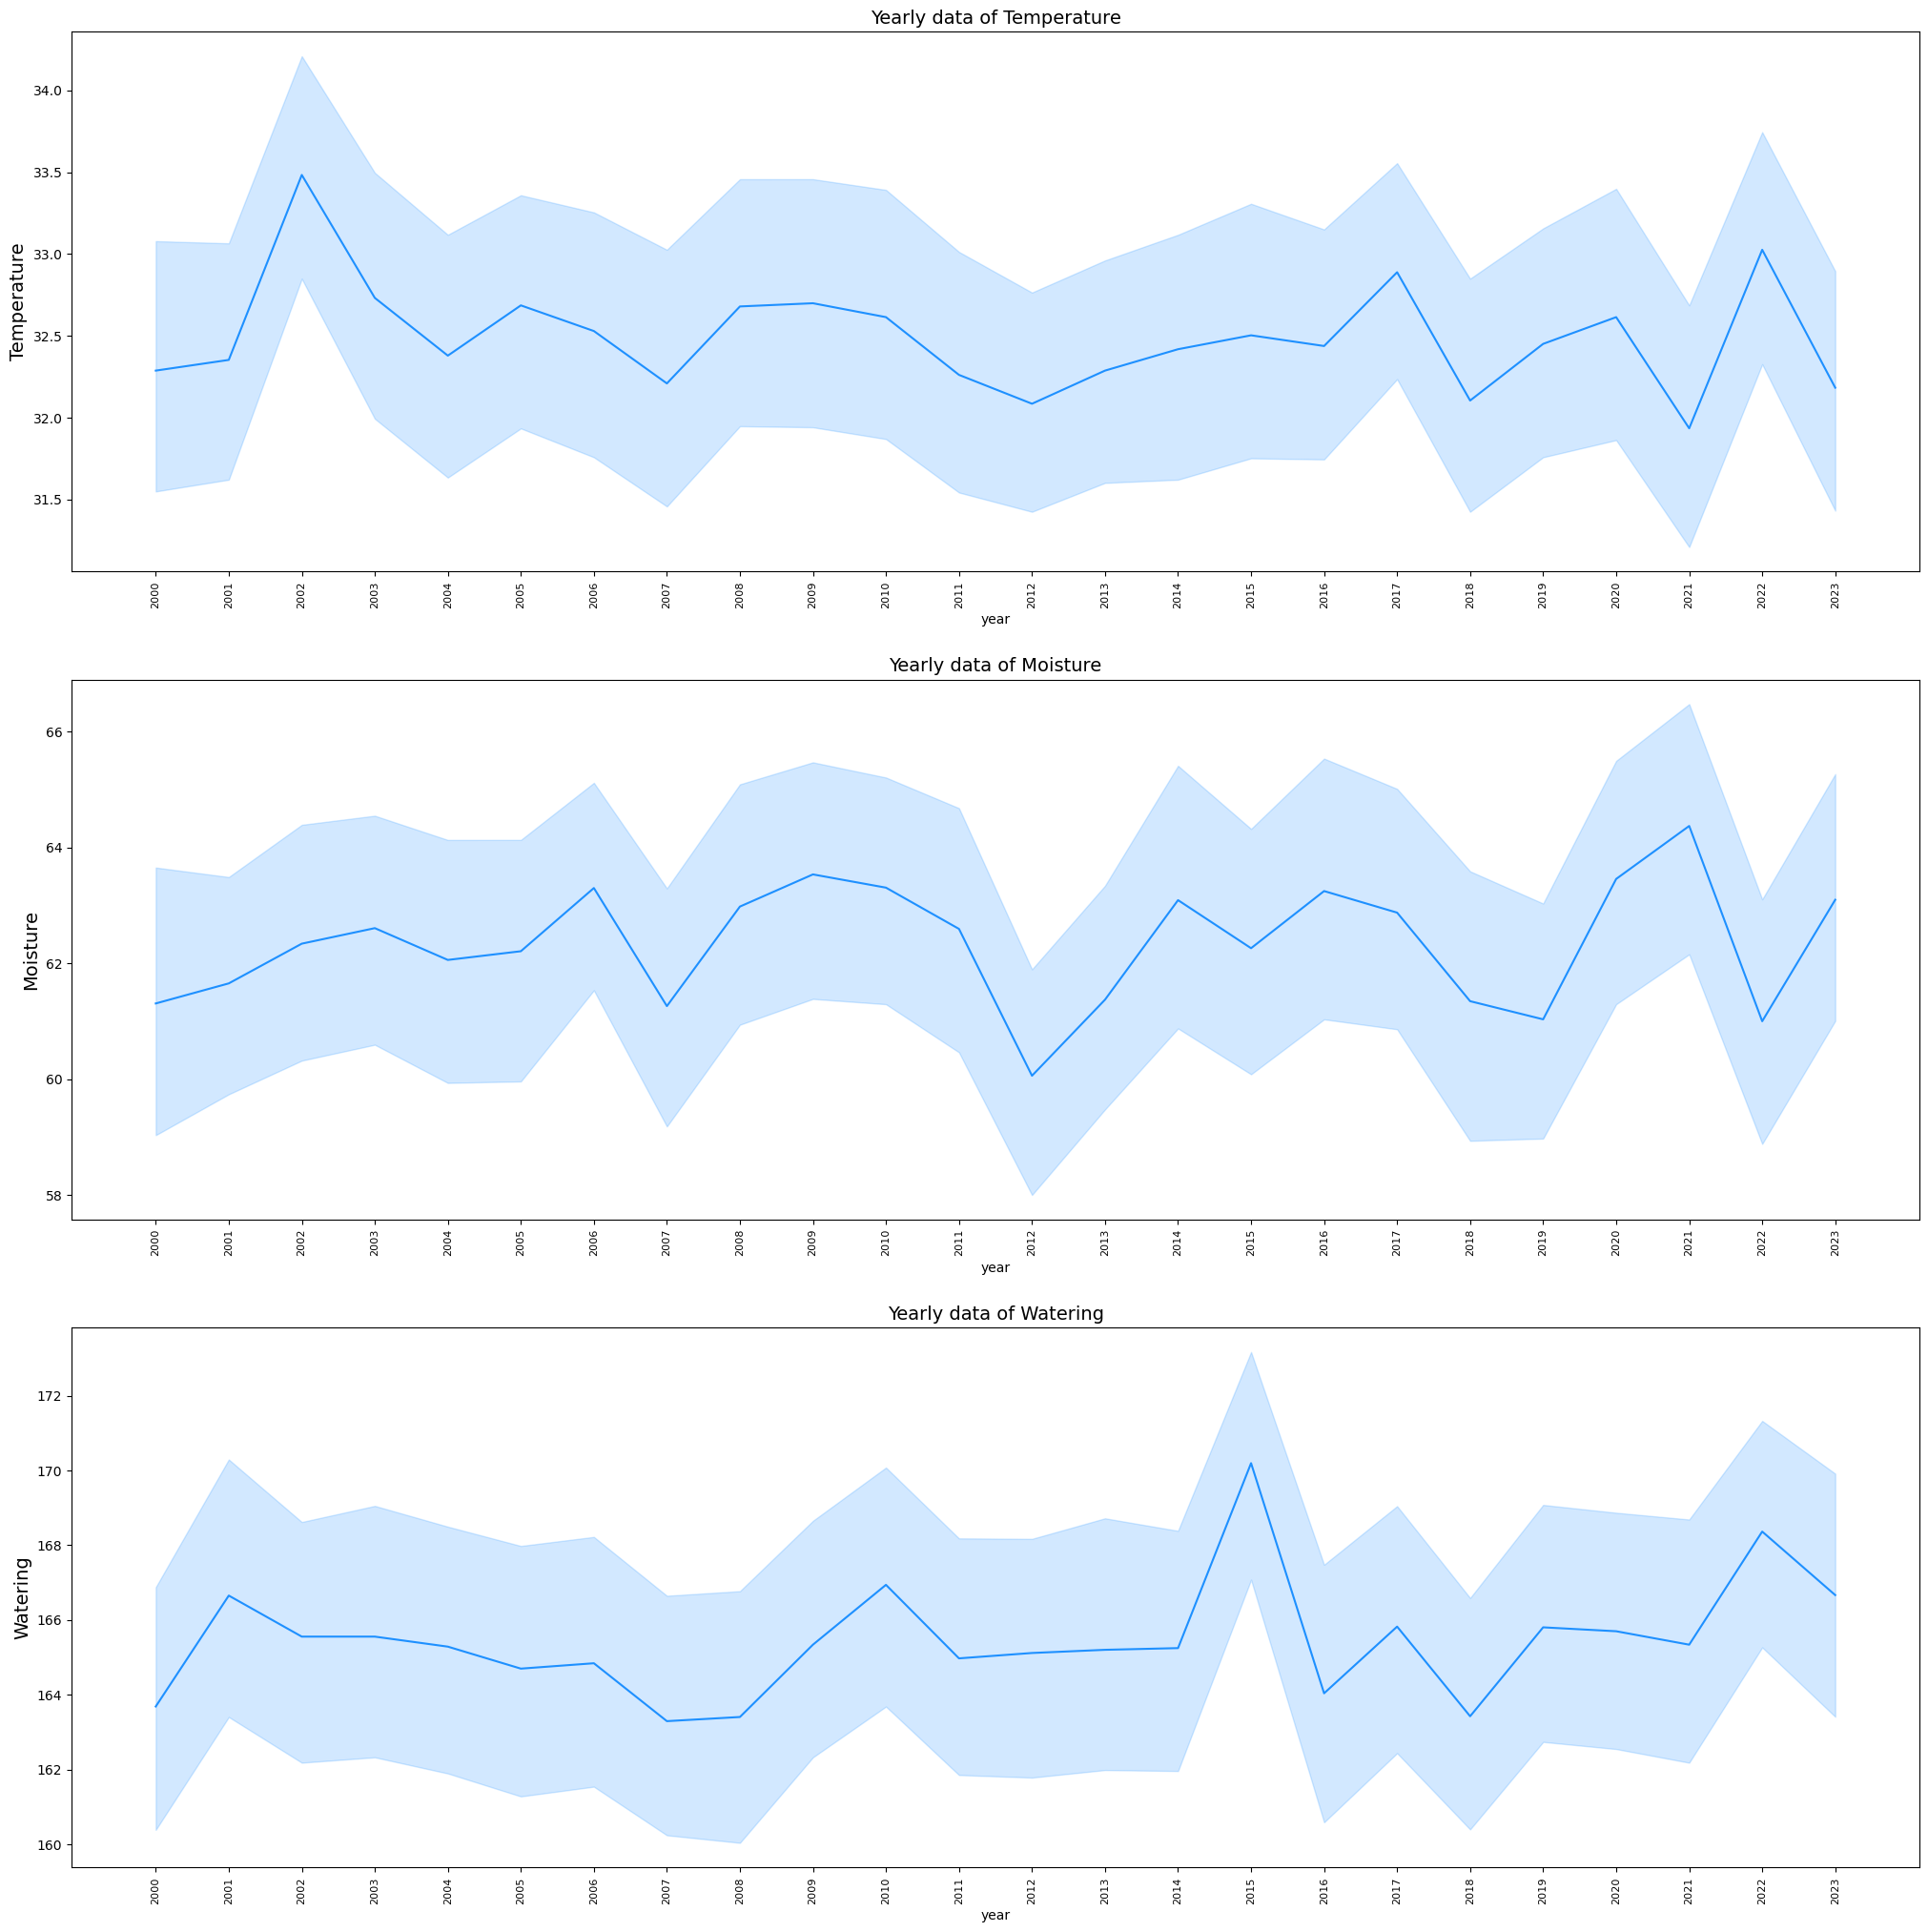

In [9]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 25))

for i, column in enumerate(data.drop(['Date', 'month', 'year', 'dayofweek', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear'], axis=1).columns):
    plot = sns.lineplot(x=data['year'], y=data[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    plot.xaxis.set_major_locator(ticker.FixedLocator(plot.get_xticks()))
    ax[i].tick_params(axis='x', labelrotation=90, labelsize=8)
    ax[i].set_title('Yearly data of {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    

    



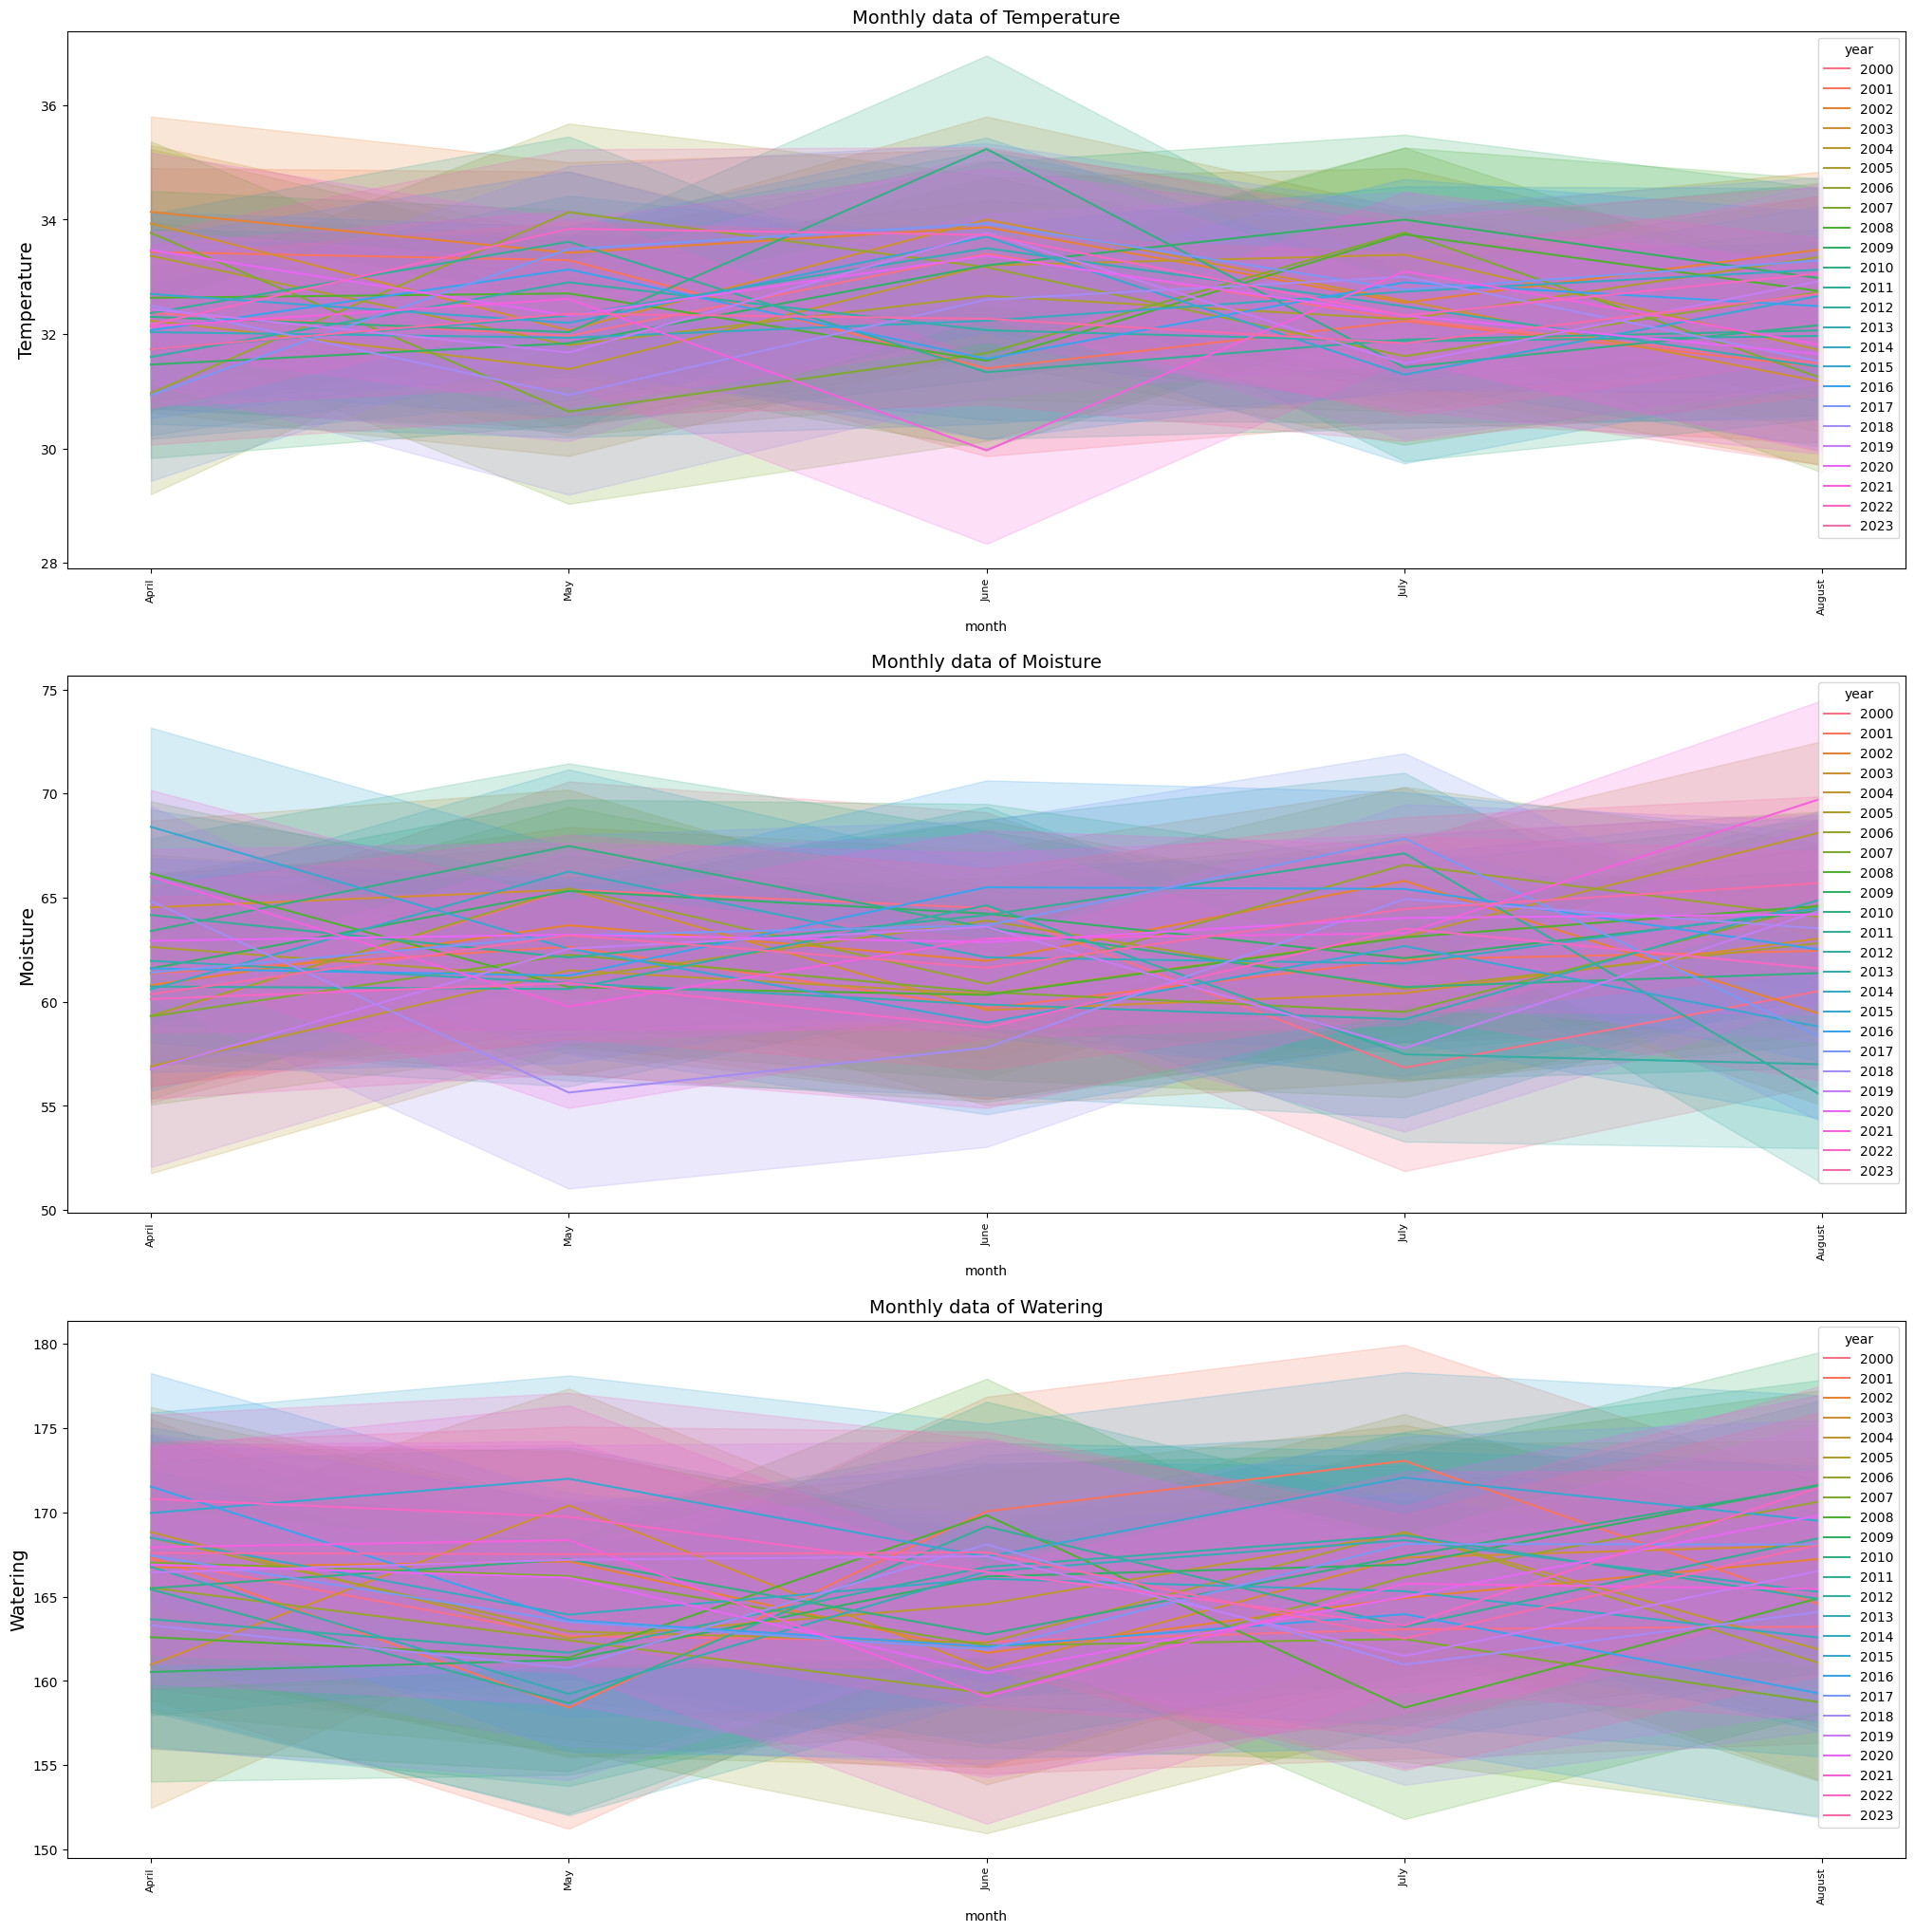

In [10]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 25))

for i, column in enumerate(data.drop(['Date', 'month', 'year', 'dayofweek', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear'], axis=1).columns):
    plot = sns.lineplot(x=data['month'], y=data[column],hue= data['year'], ax=ax[i], color='dodgerblue')
    plot.xaxis.set_major_locator(ticker.FixedLocator(plot.get_xticks()))
    ax[i].tick_params(axis='x', labelrotation=90, labelsize=8)
    ax[i].set_title('Monthly data of {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    

    



In [11]:
df.columns

Index(['Date', 'Temperature', 'Moisture', 'Watering'], dtype='object')

<AxesSubplot:>

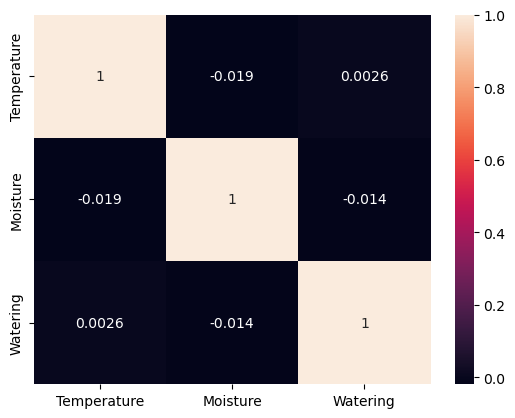

In [12]:
sns.heatmap(df.corr(), annot=True, )

In [13]:
def date_features(df, label):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    y=df[label]
    return X, y

In [14]:
X, y = date_features(df, label='Moisture')
df_moist = pd.concat([X, y], axis=1)
df_moist

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Moisture
0,Saturday,2,April,2000,92,1,13,64
1,Sunday,2,April,2000,93,2,13,41
2,Monday,2,April,2000,94,3,14,60
3,Tuesday,2,April,2000,95,4,14,56
4,Wednesday,2,April,2000,96,5,14,42
...,...,...,...,...,...,...,...,...
3667,Sunday,3,August,2023,239,27,34,68
3668,Monday,3,August,2023,240,28,35,67
3669,Tuesday,3,August,2023,241,29,35,50
3670,Wednesday,3,August,2023,242,30,35,75


In [15]:
X, y = date_features(df, label='Temperature')
df_temp = pd.concat([X, y], axis=1)
df_temp

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Temperature
0,Saturday,2,April,2000,92,1,13,30
1,Sunday,2,April,2000,93,2,13,39
2,Monday,2,April,2000,94,3,14,33
3,Tuesday,2,April,2000,95,4,14,34
4,Wednesday,2,April,2000,96,5,14,25
...,...,...,...,...,...,...,...,...
3667,Sunday,3,August,2023,239,27,34,28
3668,Monday,3,August,2023,240,28,35,35
3669,Tuesday,3,August,2023,241,29,35,28
3670,Wednesday,3,August,2023,242,30,35,37


In [16]:
X, y = date_features(df, label='Watering')
df_water = pd.concat([X, y], axis=1)
df_water

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Watering
0,Saturday,2,April,2000,92,1,13,142
1,Sunday,2,April,2000,93,2,13,183
2,Monday,2,April,2000,94,3,14,193
3,Tuesday,2,April,2000,95,4,14,174
4,Wednesday,2,April,2000,96,5,14,130
...,...,...,...,...,...,...,...,...
3667,Sunday,3,August,2023,239,27,34,162
3668,Monday,3,August,2023,240,28,35,176
3669,Tuesday,3,August,2023,241,29,35,176
3670,Wednesday,3,August,2023,242,30,35,141


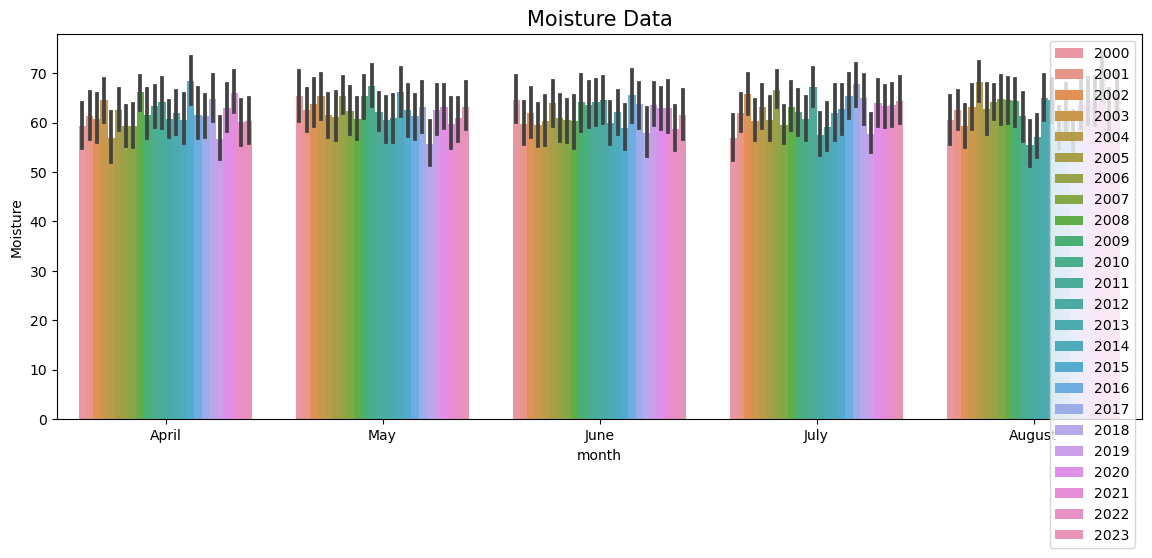

In [17]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Moisture",hue = 'year',data=df_moist)
a.set_title("Moisture Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

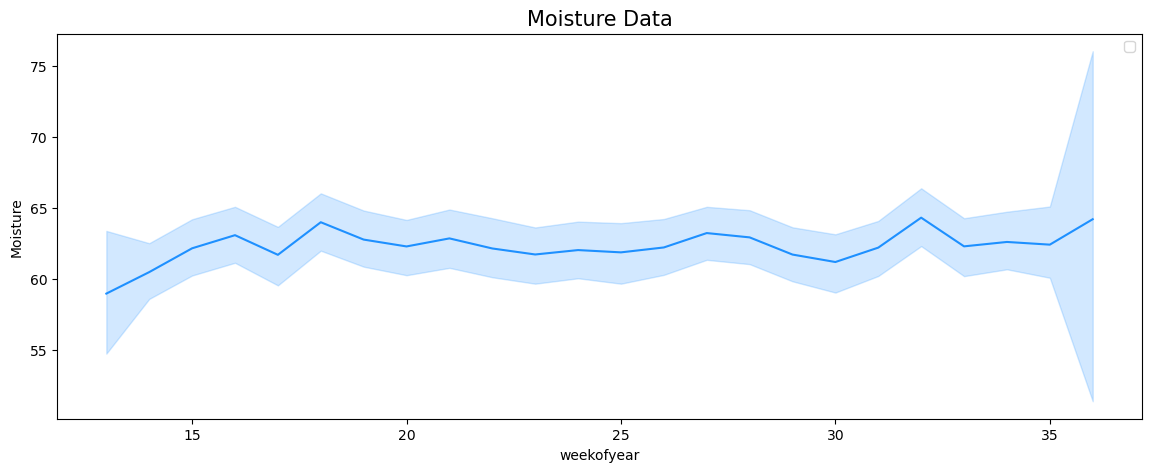

In [18]:

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.lineplot(x=df_moist['weekofyear'], y=df_moist['Moisture'].fillna(method='ffill'), color='dodgerblue')
a.set_title("Moisture Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

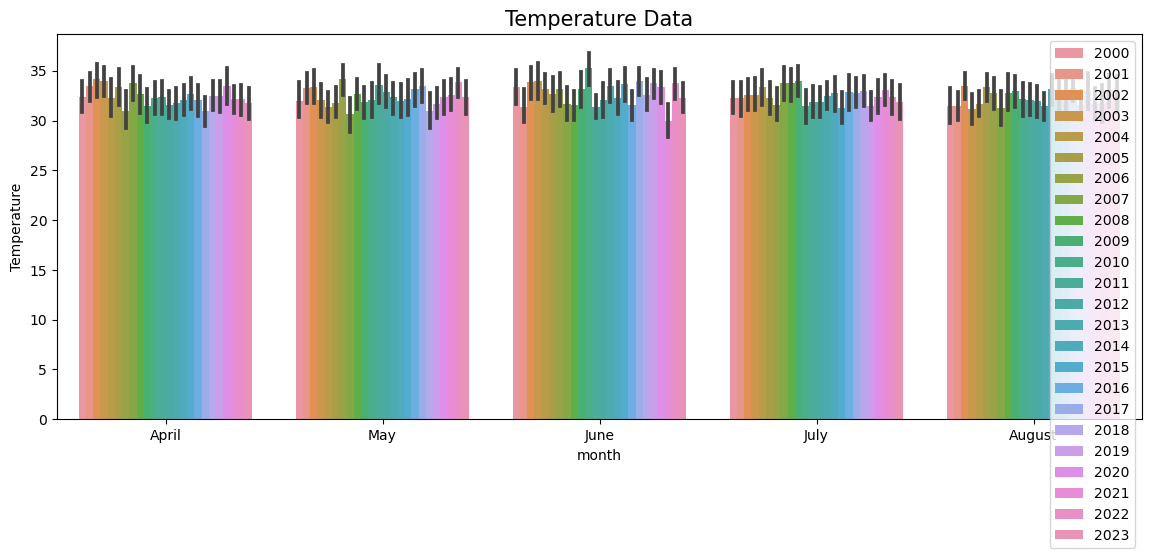

In [19]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Temperature",hue = 'year',data=df_temp)
a.set_title("Temperature Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

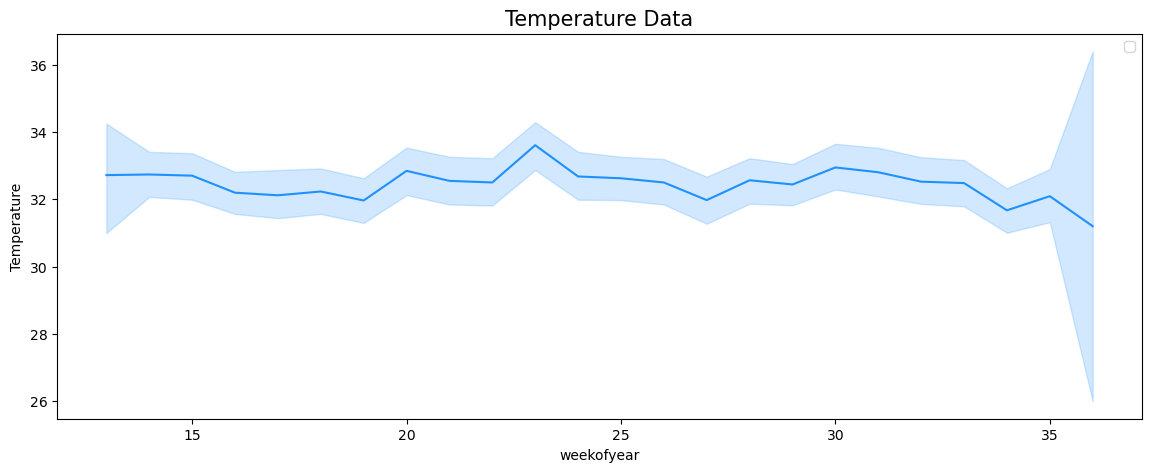

In [20]:

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.lineplot(x=df_temp['weekofyear'], y=df_temp['Temperature'].fillna(method='ffill'), color='dodgerblue')
a.set_title("Temperature Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

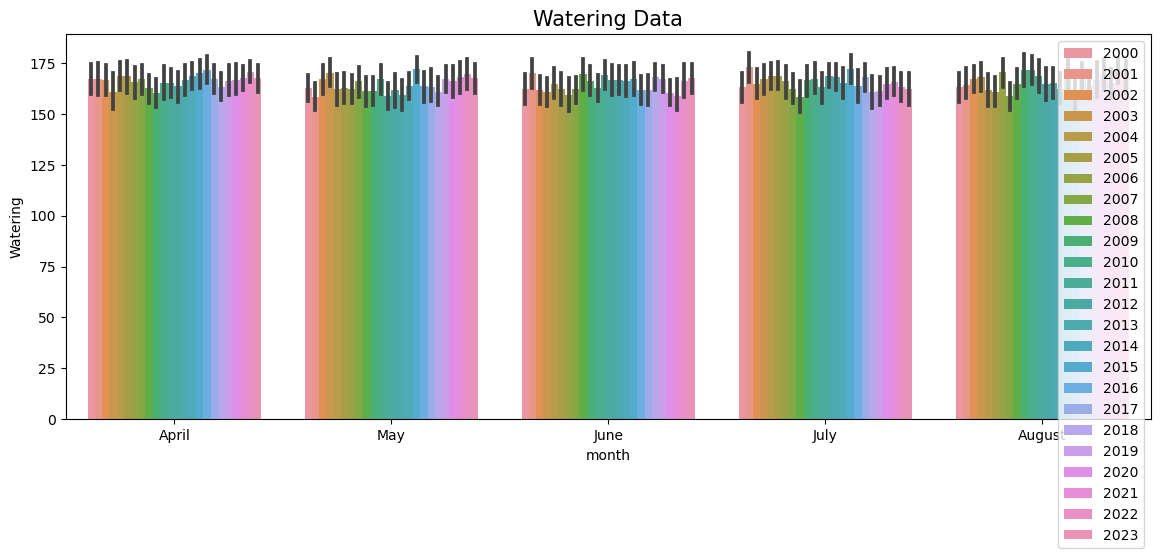

In [21]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Watering",hue = 'year',data=df_water)
a.set_title("Watering Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

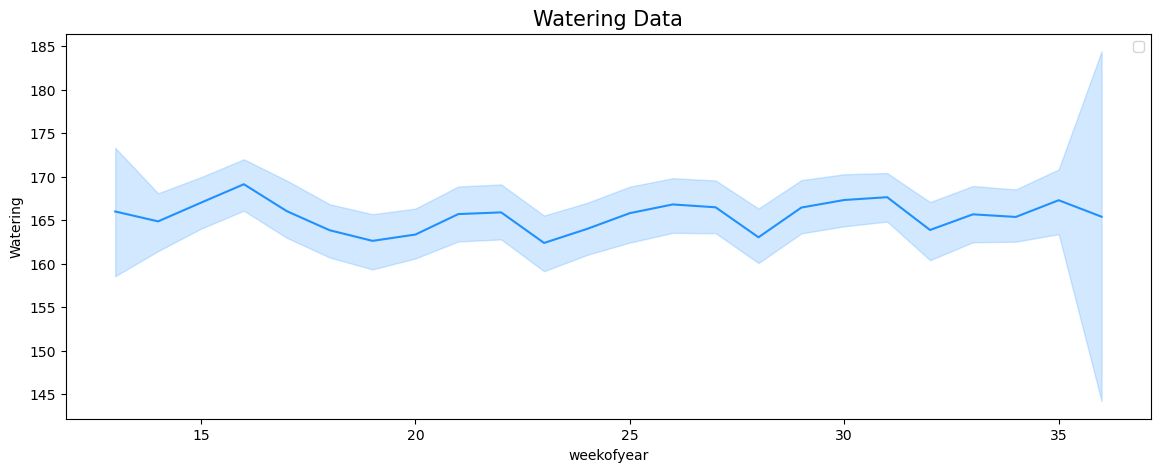

In [22]:

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.lineplot(x=df_water['weekofyear'], y=df_water['Watering'].fillna(method='ffill'), color='dodgerblue')
a.set_title("Watering Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

<AxesSubplot:xlabel='Moisture', ylabel='Count'>

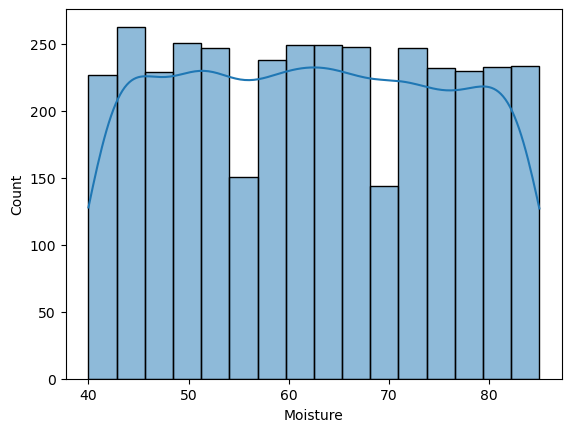

In [23]:
sns.histplot(x = df['Moisture'], kde = True)

<AxesSubplot:xlabel='Temperature', ylabel='Count'>

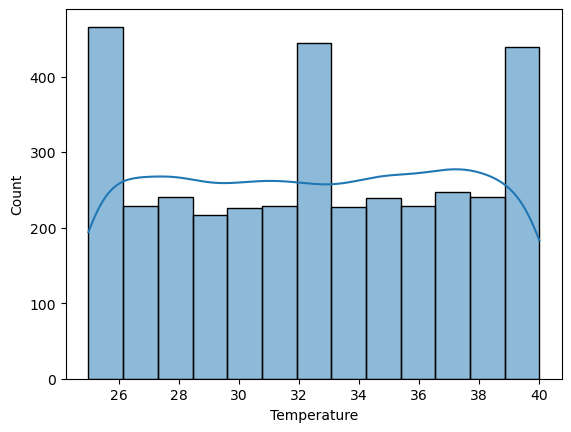

In [24]:
sns.histplot(x = df['Temperature'], kde = True)

<AxesSubplot:xlabel='Watering', ylabel='Count'>

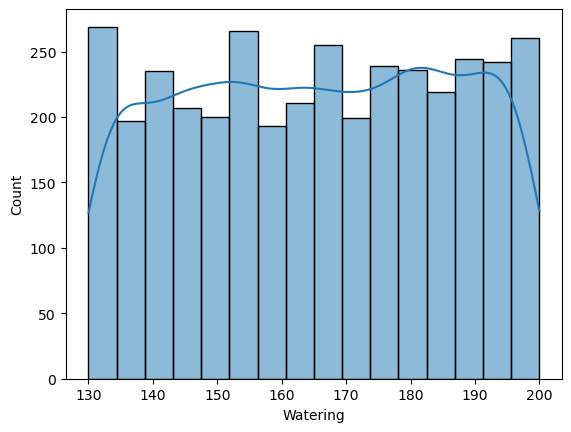

In [25]:
sns.histplot(x = df['Watering'], kde = True)

## ***Data Preprocessing***

In [26]:
train_df.head()

,Date,Temperature,Moisture,Watering
0,2007-07-06,28,52,142
1,2000-05-01,31,40,195
2,2009-04-17,29,60,153
3,2009-05-14,29,55,137
4,2020-04-08,33,66,150


In [27]:
def data_process(data):
    df= data.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df.drop(columns=['Date'], inplace=True)

    return df

In [28]:
train= data_process(train_df)
train.head()

,Temperature,Moisture,Watering,Year,Month,Day,DayOfWeek,Quarter
0,28,52,142,2007,7,6,4,3
1,31,40,195,2000,5,1,0,2
2,29,60,153,2009,4,17,4,2
3,29,55,137,2009,5,14,3,2
4,33,66,150,2020,4,8,2,2


In [29]:
test=  data_process(test_df)
test.head()

,Temperature,Moisture,Watering,Year,Month,Day,DayOfWeek,Quarter
0,35,63,130,2013,5,18,5,2
1,40,76,136,2009,8,5,2,3
2,30,63,181,2013,5,16,3,2
3,37,71,136,2022,6,21,1,2
4,28,84,150,2004,7,25,6,3


In [30]:
X = train[['Temperature', 'Moisture']]

y=  train['Watering']

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [32]:
test_x = test[['Temperature', 'Moisture']]
test_y = test['Watering']

# ***Linear Regression***


In [33]:
param_grid = {'fit_intercept': [True, False],
              
              'copy_X': [True, False]}

In [34]:
n_splits = 5

### ***1. Time series split & Grid Search***

In [35]:
tscv = TimeSeriesSplit(n_splits=n_splits)
model = LinearRegression()

In [36]:
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=tscv)

In [37]:
train.columns

Index(['Temperature', 'Moisture', 'Watering', 'Year', 'Month', 'Day',
       'DayOfWeek', 'Quarter'],
      dtype='object')

In [38]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [39]:
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'copy_X': True, 'fit_intercept': True}


In [40]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

In [41]:
mse = mean_squared_error(y_val, y_pred)
print("Mean squared error: ", mse)

Mean squared error:  421.58051943295294


### ***1.2 linear regression With KFOLD***

In [42]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores_lr = []
for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # train linear regression model
    
    best_model.fit(X_train_fold, y_train_fold)
    
    # evaluate the model on validation set
    y_val_pred = best_model.predict(X_val_fold)
    mse_scores_lr.append(mean_squared_error(y_val_fold, y_val_pred))

In [43]:
print(mse_scores_lr)

[401.6968172344993, 423.5342194491514, 433.3709464401584, 435.08738668607947, 432.52601584568555]


In [44]:
avg_mse_score_lr = sum(mse_scores_lr) / len(mse_scores_lr)

In [45]:
print(avg_mse_score_lr)

425.24307713111483


In [46]:
predicted_df_lr = test_df.copy()
pred_value= best_model.predict(test_x)
predicted_df_lr['pred_value']= pred_value
predicted_df_lr.head()

,Date,Temperature,Moisture,Watering,pred_value
0,2013-05-18,35,63,130,165.507824
1,2009-08-05,40,76,136,165.227139
2,2013-05-16,30,63,181,165.522266
3,2022-06-21,37,71,136,165.338205
4,2004-07-25,28,84,150,165.097957


In [47]:
mean_squared_error(pred_value, test_y)

423.44936752121316

# ***Decision Tree Regression***

In [48]:
from sklearn.tree import DecisionTreeRegressor


In [49]:
!pip install Optuna

In [50]:
import optuna

In [51]:
def objective(trial, data=X, target=y):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.18,random_state=3317)
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0)
    }

    model = DecisionTreeRegressor(**params)
    model.fit(train_x,train_y)
    
    preds = model.predict(test_x)
    mse = mean_squared_error(test_y, preds,squared=False)
    
    return mse

In [52]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-04-02 09:13:34,753] A new study created in memory with name: no-name-9aca8278-85e2-42e4-bebb-658f8fbba0d1
[I 2023-04-02 09:13:34,766] Trial 0 finished with value: 21.46712169686618 and parameters: {'max_depth': 30, 'min_samples_split': 26, 'min_samples_leaf': 12, 'max_features': 0.590186281050875}. Best is trial 0 with value: 21.46712169686618.
[I 2023-04-02 09:13:34,775] Trial 1 finished with value: 21.07224491869182 and parameters: {'max_depth': 10, 'min_samples_split': 26, 'min_samples_leaf': 26, 'max_features': 0.4030627959830989}. Best is trial 1 with value: 21.07224491869182.
[I 2023-04-02 09:13:34,782] Trial 2 finished with value: 21.329000450215243 and parameters: {'max_depth': 12, 'min_samples_split': 29, 'min_samples_leaf': 17, 'max_features': 0.11468884178044096}. Best is trial 1 with value: 21.07224491869182.
[I 2023-04-02 09:13:34,791] Trial 3 finished with value: 21.1995937530791 and parameters: {'max_depth': 28, 'min_samples_split': 21, 'min_samples_leaf': 21, 'm

Number of finished trials: 10
Best trial: {'max_depth': 10, 'min_samples_split': 26, 'min_samples_leaf': 26, 'max_features': 0.4030627959830989}


In [53]:
param = study.best_params

In [54]:

mse_scores_dt=[]
for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # train linear regression model
    
    dec_model = DecisionTreeRegressor(**param)

    dec_model.fit(X_train_fold, y_train_fold)
    
    # evaluate the model on validation set
    y_val_pred = dec_model.predict(X_val_fold)
    mse_scores_dt.append(mean_squared_error(y_val_fold, y_val_pred))

In [55]:
mse_scores_dt

[438.7364311243361,
 441.1237301631198,
 457.9800664761432,
 450.19243847839743,
 464.92754048371546]

In [56]:
avg_mse_score_dt=sum(mse_scores_dt)/len(mse_scores_dt)

In [57]:
print(avg_mse_score_dt)

450.5920413451424


In [58]:
predicted_df_dt = test_df.copy()
pred_value_dt= dec_model.predict(test_x)
predicted_df_dt['pred_value']= pred_value_dt
predicted_df_dt.head()

,Date,Temperature,Moisture,Watering,pred_value
0,2013-05-18,35,63,130,171.653333
1,2009-08-05,40,76,136,164.722222
2,2013-05-16,30,63,181,162.843750
3,2022-06-21,37,71,136,166.372549
4,2004-07-25,28,84,150,166.244898


In [59]:
mean_squared_error(pred_value_dt, test_y)

440.2545578457831

# ***CAT Boost Regressor***

In [60]:
!pip install catboost

In [61]:
from catboost import CatBoostRegressor

In [62]:
def objective_cat(trial, data=X, target=y):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.18,random_state=3317)
    
    param = {
      
      "eval_metric": trial.suggest_categorical("loss_function", ["RMSE","MAE"]),
      'random_state': 48,
      'iterations': 3500,
      'sampling_frequency': "PerTree",
      'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
      'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.3, 1.0),
      'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
      'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
      'depth': trial.suggest_categorical('max_depth', [2, 4, 6, 8, 14]),

      'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
      }
    

 
    model = CatBoostRegressor(**param)  
    
    model.fit(train_x,train_y, verbose=0)
    
    preds = model.predict(test_x)
    
    mse = mean_squared_error(test_y, preds,squared=False)
    
    return mse

In [63]:
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=10)
print('Number of finished trials:', len(study_cat.trials))
print('Best trial:', study_cat.best_trial.params)

[I 2023-04-02 09:13:46,951] A new study created in memory with name: no-name-1541f5ce-d259-44c6-947d-e51e02ed1a30
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.
[I 2023-04-02 09:13:48,562] Trial 0 finished with value: 20.998313278115386 and parameters: {'loss_function': 'RMSE', 'reg_lambda': 0.6986147930724302, 'colsample_bylevel': 0.6039392500103966, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_samples': 151}. Best is trial 0 with value: 20.998313278115386.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

Number of finished trials: 10
Best trial: {'loss_function': 'RMSE', 'reg_lambda': 0.6986147930724302, 'colsample_bylevel': 0.6039392500103966, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_samples': 151}


In [64]:
param_cat = study_cat.best_params

In [65]:

mse_scores_cat=[]
for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # train linear regression model
    
    xgb_model = CatBoostRegressor(**param_cat)

    xgb_model.fit(X_train_fold, y_train_fold)
    
    # evaluate the model on validation set
    y_val_pred = xgb_model.predict(X_val_fold)
    mse_scores_cat.append(mean_squared_error(y_val_fold, y_val_pred))

0:	learn: 20.7523534	total: 491us	remaining: 491ms
1:	learn: 20.7516561	total: 1.24ms	remaining: 620ms
2:	learn: 20.7511689	total: 1.7ms	remaining: 565ms
3:	learn: 20.7511689	total: 1.96ms	remaining: 488ms
4:	learn: 20.7508140	total: 2.37ms	remaining: 472ms
5:	learn: 20.7495497	total: 2.75ms	remaining: 455ms
6:	learn: 20.7495451	total: 3.06ms	remaining: 435ms
7:	learn: 20.7495451	total: 3.28ms	remaining: 407ms
8:	learn: 20.7488863	total: 3.62ms	remaining: 398ms
9:	learn: 20.7484308	total: 4ms	remaining: 396ms
10:	learn: 20.7477109	total: 4.37ms	remaining: 393ms
11:	learn: 20.7472221	total: 4.71ms	remaining: 388ms
12:	learn: 20.7469890	total: 5.05ms	remaining: 383ms
13:	learn: 20.7469890	total: 5.3ms	remaining: 373ms
14:	learn: 20.7467019	total: 5.65ms	remaining: 371ms
15:	learn: 20.7462379	total: 6.01ms	remaining: 370ms
16:	learn: 20.7462374	total: 6.35ms	remaining: 367ms
17:	learn: 20.7460137	total: 6.71ms	remaining: 366ms
18:	learn: 20.7459545	total: 7.08ms	remaining: 366ms
19:	learn

In [66]:
avg_mse_score_cat=sum(mse_scores_cat)/len(mse_scores_cat)

print(avg_mse_score_cat)

427.3338006260607


In [67]:
predicted_df_cat = test_df.copy()
pred_value_cat= xgb_model.predict(test_x)
predicted_df_cat['pred_value']= pred_value_cat
predicted_df_cat.head()

,Date,Temperature,Moisture,Watering,pred_value
0,2013-05-18,35,63,130,166.184001
1,2009-08-05,40,76,136,166.192588
2,2013-05-16,30,63,181,166.459345
3,2022-06-21,37,71,136,165.454905
4,2004-07-25,28,84,150,164.267345


In [68]:
mean_squared_error(pred_value_cat, test_y)

425.15524607461793